In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn # All relavent building blocks for neural networks

torch.__version__

'2.1.0+cu121'

In [ ]:
# Preparing and loading data

# Creating known parameters for linear regression formula
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [ ]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split] # Not using randomness yet, for simplicity
X_test, y_test = X[train_split:], y[train_split:]

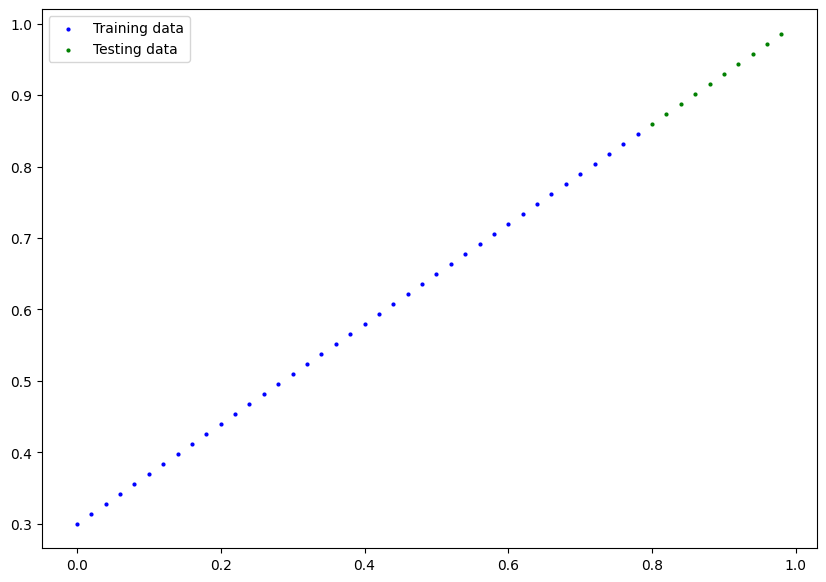

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  plt.legend()

plot_predictions()

In [ ]:
"""
torch.nn contains building blocks for computational graphs (e.g. neural networks)
torch.nn.Paramete - what model will try to learn, usally a layer from torch.nn
torch.nn.Module - the base class for all NN modules. When subclassed, override forward()
torch.optim - PyTorch optimizer, used for GD and others
forward() - defines forward computation
torch.utils.data.Dataset - represents a map between key (label) and sample (features) pairs in data (e.g. images and labels)
torch.utils.data.Dataloader - creates Python iterable over torch Dataset (allows iteration through data)
"""

# Create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Iniitalize model parameters
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # requires_grad = True and torch.float are defaults
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Forward method, needed since we subclassed nn.Module
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

In [ ]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

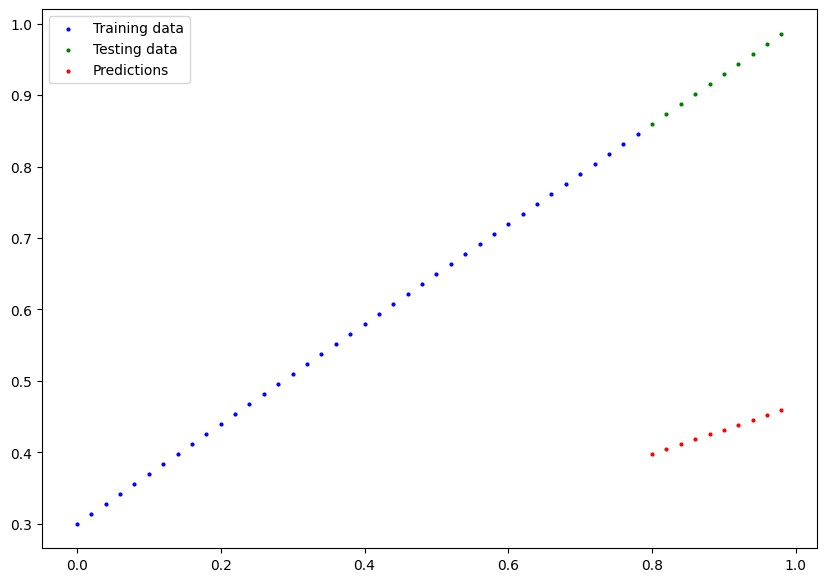

In [ ]:
with torch.inference_mode(): # Stops gradient tracking (accelerates)
  y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

In [ ]:
loss_fn = nn.L1Loss() # Mean absolute error (MAE)
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.01) # Stochastic gradient descent, and learning rate of 0.01

In [ ]:
# Building a training loop and testing loop in PyTorch
# Iterate through data --> forward pass --> calculate loss --> optimizer zero grad --> backpropogation --> optimizer step

# An epoch is one loop through the data
epochs = 250

epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  model_0.train() # Sets all parameters to require gradients (that need it)

  y_pred = model_0(X_train) # Forward pass
  loss = loss_fn(y_pred, y_train) # Calculate loss (input first, target second)
  optimizer.zero_grad() # Zero, resetting each iteration
  loss.backward() # Perform backpropogation
  optimizer.step() # Step the optimizer (GD)

  model_0.eval() # Testing, turns off gradient tracking
  with torch.inference_mode():
    test_pred = model_0(X_test)
    test_loss = loss_fn(test_pred, y_test)
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Ep

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

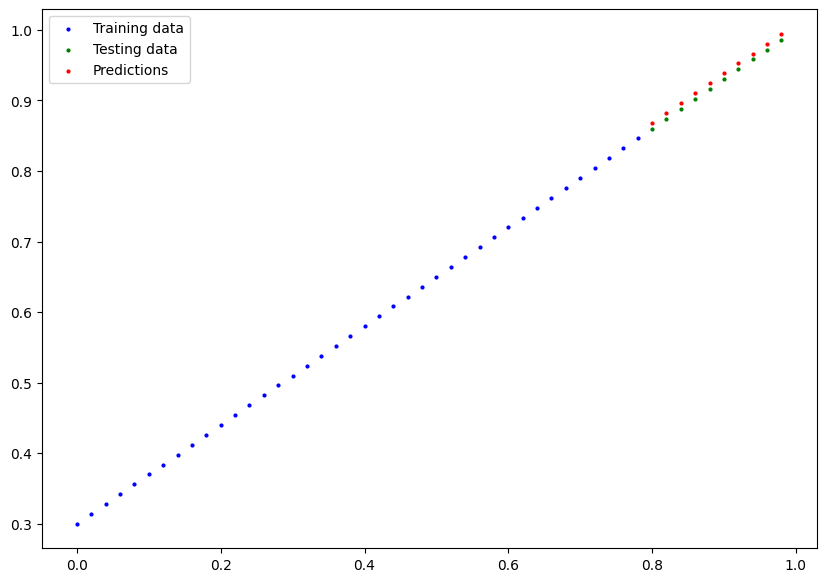

In [ ]:
with torch.inference_mode(): # Stops gradient tracking (accelerates)
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

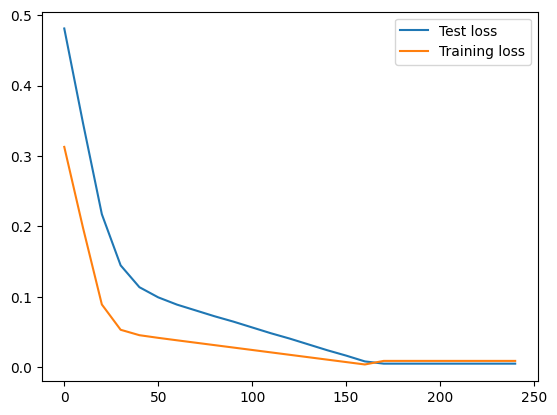

In [ ]:
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label="Training loss")
plt.legend()
plt.show()

In [ ]:
# torch.save() - allows you to save PyTorch object
# torch.load() - allows you to load a saved PyTorch object
# torch.nn.Module.load_state_dict() - allows you to load model's saved state dictionary

from pathlib import Path

MODEL_PATH = Path("models") # Creating models directory
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "1_pytorch_workflow_model_0.pth" # Creating model save path
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


print(f"Saving model to: {MODEL_SAVE_PATH}") # Save model state_dict --> can be saved, downloaded, re-uploaded
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/1_pytorch_workflow_model_0.pth


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1674 Mar  2 04:38 1_pytorch_workflow_model_0.pth


In [ ]:
# Loading a PyTorch model

loaded_model_0 = LinearRegressionModel() # New instance of model class
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH)) # Load the saved state_dict

<All keys matched successfully>

In [ ]:
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
  old_model_preds = model_0(X_test)

loaded_model_preds == old_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")
!nvidia-smi

Using device: cuda
Sat Mar  2 04:38:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"

weight = 0.7
bias = 0.3

start = 0; end = 1; step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

class LinearRegressionModuleV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x:torch.Tensor):
    return self.linear_layer(x) # Applies linear transform y = xA^T + b

model_1 = LinearRegressionModuleV2()
model_1.to(device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

epochs = 200

for epoch in range(epochs):
  model_1.train()
  y_pred = model_1(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.14943397045135498 | Test loss: 0.11655852943658829
Epoch: 10 | Loss: 0.03422394394874573 | Test loss: 0.018151450902223587
Epoch: 20 | Loss: 0.015005416236817837 | Test loss: 0.03433716297149658
Epoch: 30 | Loss: 0.01156583335250616 | Test loss: 0.026064617559313774
Epoch: 40 | Loss: 0.008131923153996468 | Test loss: 0.018478959798812866
Epoch: 50 | Loss: 0.004701016936451197 | Test loss: 0.010206419043242931
Epoch: 60 | Loss: 0.003437020583078265 | Test loss: 0.01276823878288269
Epoch: 70 | Loss: 0.003437020583078265 | Test loss: 0.01276823878288269
Epoch: 80 | Loss: 0.003437020583078265 | Test loss: 0.01276823878288269
Epoch: 90 | Loss: 0.003437020583078265 | Test loss: 0.01276823878288269
Epoch: 100 | Loss: 0.003437020583078265 | Test loss: 0.01276823878288269
Epoch: 110 | Loss: 0.003437020583078265 | Test loss: 0.01276823878288269
Epoch: 120 | Loss: 0.003437020583078265 | Test loss: 0.01276823878288269
Epoch: 130 | Loss: 0.003437020583078265 | Test loss: 0.012768

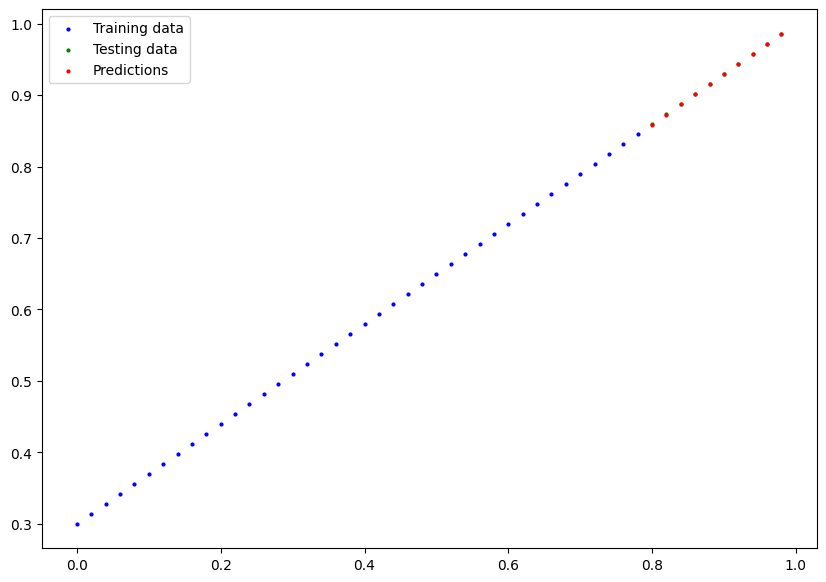

In [43]:
model_1.eval()
with torch.inference_mode():
  y_preds = model_1(X_test)

plot_predictions(predictions=y_preds.cpu())

In [44]:
MODEL_PATH = Path("models") # Creating models directory
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "1_pytorch_workflow_model_1.pth" # Creating model save path
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


print(f"Saving model to: {MODEL_SAVE_PATH}") # Save model state_dict --> can be saved, downloaded, re-uploaded
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/1_pytorch_workflow_model_1.pth


In [48]:
loaded_model_1 = LinearRegressionModuleV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_1.to(device)

loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_1(X_test)
  old_model_preds = model_1(X_test)

loaded_model_preds == old_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')